# CDC

https://wonder.cdc.gov/

There are 6 tables in database
- **mcd99_cod:** provides data on a cod basis (1999 - 2020 data)
- **mcd18_cod:** provides data on a cod basis (2018+)
- **mcd18_monthly:** provides monthly data (2018+)
- **mi:** provides data from on a more aggregate level (1979-2020)
- **mcd99_check:** provides a check to the cod table as it isn't using grouping (1999 - 2020 data)
- **mcd18_check:** provides a check to the cod table as it isn't using groupings (2018+ data)

sources:
- 1979-1998: https://wonder.cdc.gov/controller/datarequest/D16
- 1999-2020: https://wonder.cdc.gov/controller/datarequest/D76
- 2018+: https://wonder.cdc.gov/controller/datarequest/D176

code support:
- https://github.com/alipphardt/cdc-wonder-api


## Import

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import plotly.express as px
import polars as pl
from sklearn.linear_model import LinearRegression

os.chdir("../../")
sys.path.insert(0, os.getcwd())

In [2]:
from morai.experience import charters
from morai.integrations import cdc
from morai.utils import helpers, sql

In [3]:
pd.options.display.float_format = "{:,.2f}".format

In [4]:
db_filepath = r"files/integrations/cdc/cdc.sql"

In [5]:
tables = sql.get_tables(db_filepath=db_filepath)
tables

['mcd99_check',
 'mcd18_check',
 'mcd99_mi',
 'mcd99_cod',
 'mcd79_check',
 'mcd79_mi',
 'mcd18_cod',
 'mcd18_monthly',
 'mcd18_mi']

## COD

### SQL
Load from SQL database

In [6]:
mcd99_cod = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd99_cod")

In [7]:
mcd18_cod = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd18_cod")

### Aggregate
Aggregating the historical and provisional and mapping columns to more friendly names

In [40]:
# variable to map
category_col = "simple_grouping"

In [41]:
# filter and concat
mcd18_cod = mcd18_cod[mcd18_cod["year"] >= 2021]
cod_all = pd.concat([mcd99_cod, mcd18_cod], ignore_index=True)

In [42]:
# map the variable from reference
cod_all = cdc.map_reference(
    df=cod_all, col=category_col, on_dict={"icd_-_sub-chapter": "wonder_sub_chapter"}
)

In [11]:
# create totals column
totals = cod_all.groupby("year").sum(numeric_only=True).reset_index()
totals[category_col] = "total"
totals["age_groups"] = "total"
cod_all = pd.concat([cod_all, totals], ignore_index=True)

In [12]:
category_orders = charters.get_category_orders(
    df=cod_all, category=category_col, measure="deaths"
)

### Predict

In [14]:
# train the data based on year and the category using linear regression
train_df = cod_all[(cod_all["year"] >= 2015) & (cod_all["year"] <= 2019)]
train_df = train_df.groupby(["year", category_col])["deaths"].sum().reset_index()

In [ ]:
# create the models
models = {}
for cod in train_df[category_col].unique():
    cod_subset = train_df[train_df[category_col] == cod]
    X = (cod_subset["year"] - 2015).values.reshape(-1, 1)
    y = cod_subset["deaths"].values
    model = LinearRegression().fit(X, y)
    models[cod] = {
        "model": model,
        "coef": model.coef_[0],
        "intercept": model.intercept_,
    }

In [ ]:
# make the predictions
test_df = cod_all[(cod_all["year"] >= 2020)]
test_df = test_df.groupby(["year", category_col])["deaths"].sum().reset_index()

for cod, model in models.items():
    mask = test_df[category_col] == cod
    if mask.sum() > 0:
        X = (test_df.loc[mask, "year"] - 2015).values.reshape(-1, 1)
        test_df.loc[mask, "pred"] = model["model"].predict(X)

test_df["diff_abs"] = test_df["deaths"] - test_df["pred"]
test_df["diff_pct"] = (test_df["deaths"] - test_df["pred"]) / test_df["pred"]

### Chart

In [ ]:
charters.chart(
    df=cod_all,
    x_axis="year",
    y_axis="deaths",
    color=category_col,
    type="area",
    category_orders=category_orders,
)

In [ ]:
cod_all["crude_rate"] = cod_all["deaths"] / cod_all["population"] * 1000

In [ ]:
cod_all[(cod_all["simple_grouping"] == "neoplasms") & (cod_all["year"] == 2023)]

In [ ]:
fig = px.treemap(
    cod_all[(cod_all["simple_grouping"] != "total") & (cod_all["year"] == 2023)],
    path=[px.Constant("all"), "simple_grouping", "icd_-_sub-chapter"],
    values="deaths",
)
fig

In [ ]:
summary = charters.chart(
    df=test_df,
    x_axis="year",
    y_axis="diff_pct",
    color=category_col,
    type="area",
    category_orders=category_orders,
    display=False,
)
pivot = summary.pivot(index=category_col, columns="year", values="diff_pct")
pivot.index = pd.Categorical(
    pivot.index, categories=category_orders[category_col], ordered=True
)
pivot = pivot.sort_index().reset_index()
pivot

In [ ]:
summary = charters.chart(
    df=test_df,
    x_axis="year",
    y_axis="diff_abs",
    color=category_col,
    type="area",
    category_orders=category_orders,
    display=False,
)
pivot = summary.pivot(index=category_col, columns="year", values="diff_abs")
pivot.index = pd.Categorical(
    pivot.index, categories=category_orders[category_col], ordered=True
)
pivot = pivot.sort_index()
pivot

In [246]:
deaths_pivot, names_pivot = cdc.get_top_deaths_by_age_group(df=cod_all, year=2018)

 2024-12-08 16:23:05 | morai.utils.helpers | WARNING  | There are common columns between the DataFrames: {'simple_grouping'} 


## Monthly

### SQL

In [ ]:
mcd18_monthly = cdc.get_cdc_data_sql(
    db_filepath=db_filepath, table_name="mcd18_monthly"
)

### Chart

In [ ]:
charters.chart(
    df=mcd18_monthly,
    x_axis="month",
    y_axis="deaths",
    type="area",
)

## MI

### SQL

In [ ]:
mcd79_mi = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd79_mi")
mcd99_mi = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd99_mi")
mcd18_mi = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd18_mi")
mcd18_mi = mcd18_mi[mcd18_mi["year"] >= 2021]
mi = pd.concat([mcd79_mi, mcd99_mi, mcd18_mi], axis=0, ignore_index=True)

In [ ]:
mi = cdc.map_reference(
    df=mi, col="value", on_dict={"age_groups": "key"}, sheet_name="mapping"
)
mi = mi.drop("age_groups", axis=1)
mi = mi.rename(columns={"value": "age_groups"})

### Calculate

In [ ]:
# filters
mi = mi[mi["year"] < 2020]

In [ ]:
mi_df = cdc.calc_mi(df=mi, rolling=10)

### Chart

In [ ]:
charters.compare_rates(
    df=mi_df,
    x_axis="year",
    rates=["1_year_mi", "10_year_mi", "whl_3"],
)

In [ ]:
mi_df.tail(10)

## Excess

In [ ]:
import importlib
importlib.reload(cdc)

### SQL

In [824]:
mcd99_mi = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd99_mi")
mcd18_mi = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd18_mi")
mcd99_mi = mcd99_mi[mcd99_mi["year"] <= 2017]
excess = pd.concat([mcd99_mi, mcd18_mi], axis=0, ignore_index=True)

In [825]:
excess = cdc.map_reference(
    df=excess, col="value", on_dict={"age_groups": "key"}, sheet_name="mapping", category="bin_age_int"
)
excess = excess.rename(columns={'value': 'mapped_age'})

In [826]:
excess_grouped = (
    excess.groupby(["year", "mapped_age"], observed=True)
    .sum(numeric_only=True)
    .reset_index()
)
excess_grouped = excess_grouped[(excess_grouped["year"] >= 2015) & (excess_grouped["year"] <= 2024)].copy()
excess_grouped["qx_raw"] = excess_grouped["deaths"] / excess_grouped["population"]

### Calculate

In [827]:
train_df = excess_grouped[(excess_grouped["year"] >= 2015) & (excess_grouped["year"] <= 2019)].copy()
model = models.LeeCarter(
    age_col="mapped_age",
    year_col="year",
    actual_col="deaths",
    expose_col="population",
    interval=1,
)
fit_df = model.structure_df(train_df)
fit_df = model.fit(fit_df)

 2025-02-08 11:07:37 | morai.forecast.models | INFO     | initialized LeeCarter 
 2025-02-08 11:07:37 | morai.forecast.models | INFO     | grouping data by age and year 
 2025-02-08 11:07:37 | morai.forecast.models | INFO     | calculating qx_raw rates using deaths and population 
 2025-02-08 11:07:37 | morai.forecast.models | INFO     | floored 0 rates to 0.000001 and capped 0 rates to 0.999999. 
 2025-02-08 11:07:37 | morai.forecast.models | INFO     | crude_df shape: (55, 5) 
 2025-02-08 11:07:37 | morai.forecast.models | INFO     | creating Lee Carter model with qx_raw rates... 
 2025-02-08 11:07:37 | morai.forecast.models | INFO     | age range: 0, 85 
 2025-02-08 11:07:37 | morai.forecast.models | INFO     | year range: 2015, 2019 
 2025-02-08 11:07:37 | morai.forecast.models | INFO     | creating `11` intervals 
 2025-02-08 11:07:37 | morai.forecast.models | INFO     | adding qx_lc to lc_df 


In [828]:
forecast_df = model.forecast(years=5)
forecast_df = pd.concat(
    [fit_df[["year", "mapped_age", "qx_lc"]], forecast_df], axis=0
).reset_index()

 2025-02-08 11:07:38 | morai.forecast.models | INFO     | forecasting qx_lc using deterministic random walk... 


In [829]:
excess_grouped = pd.merge(
    excess_grouped,
    forecast_df[["mapped_age", "year", "qx_lc"]],
    on=["mapped_age", "year"],
    how="left",
)
excess_grouped["deaths_lc"] = excess_grouped["population"] * excess_grouped["qx_lc"]

In [830]:
train_df = excess_grouped[(excess_grouped["year"] >= 2015) & (excess_grouped["year"] <= 2019)].copy()
model = models.CBD(
    age_col="mapped_age",
    year_col="year",
    actual_col="deaths",
    expose_col="population",
    interval=3,
)
fit_df = model.structure_df(train_df)
fit_df = model.fit(fit_df)

 2025-02-08 11:07:41 | morai.forecast.models | INFO     | initialized CBD 
 2025-02-08 11:07:41 | morai.forecast.models | INFO     | grouping data by age and year 
 2025-02-08 11:07:41 | morai.forecast.models | INFO     | calculating qx_raw rates using deaths and population 
 2025-02-08 11:07:41 | morai.forecast.models | INFO     | floored 0 rates to 0.000001 and capped 0 rates to 0.999999. 
 2025-02-08 11:07:41 | morai.forecast.models | INFO     | cbd_df shape: (55, 5) 
 2025-02-08 11:07:41 | morai.forecast.models | INFO     | creating CBD model with qx_raw rates... 
 2025-02-08 11:07:41 | morai.forecast.models | INFO     | age range: 0, 85 
 2025-02-08 11:07:41 | morai.forecast.models | INFO     | year range: 2015, 2019 
 2025-02-08 11:07:41 | morai.forecast.models | INFO     | creating `3` intervals 
 2025-02-08 11:07:41 | morai.forecast.models | INFO     | adding qx_cbd to cbd_df 


In [831]:
forecast_df = model.forecast(years=5)
forecast_df = pd.concat(
    [fit_df[["year", "mapped_age", "qx_cbd"]], forecast_df], axis=0
).reset_index()

 2025-02-08 11:07:42 | morai.forecast.models | INFO     | forecasting qx_cbd using deterministic random walk... 


In [832]:
excess_grouped = pd.merge(
    excess_grouped,
    forecast_df[["mapped_age", "year", "qx_cbd"]],
    on=["mapped_age", "year"],
    how="left",
)
excess_grouped["deaths_cbd"] = excess_grouped["population"] * excess_grouped["qx_cbd"]

### Chart

 2025-02-08 11:10:36 | morai.experience.charters | INFO     | The weights list is 1 long and should be 3 long. Using the first weight for all weights. 


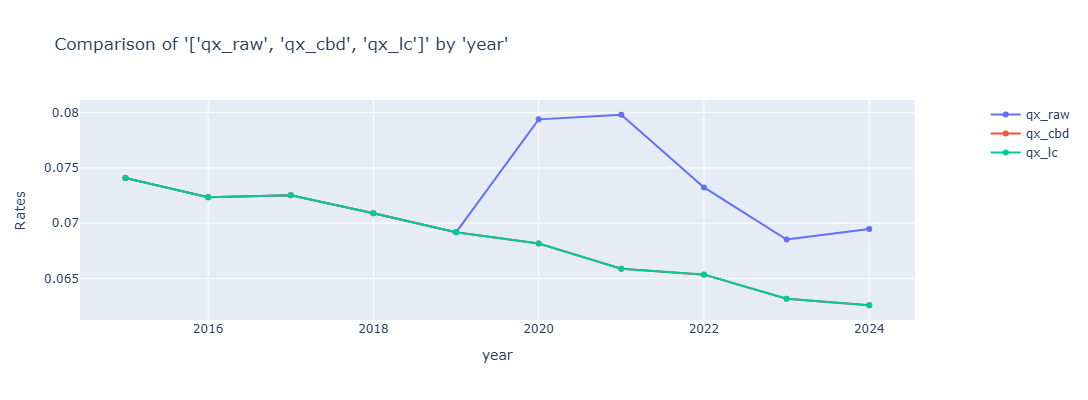

In [839]:
charters.compare_rates(
    excess_grouped[excess_grouped['mapped_age']>=75],
    x_axis="year",
    rates=["qx_raw", "qx_cbd", "qx_lc"],
    weights=["population"],
)

In [836]:
result = excess_grouped.groupby(["year"], observed=True).sum(numeric_only=True).reset_index()
result["excess_lc"] = result["deaths"] / result["deaths_lc"]
result["qx_raw"] = result["deaths"] / result["population"]
result["qx_lc"] = result["deaths_lc"] / result["population"]
result["excess_cbd"] = result["deaths"] / result["deaths_cbd"]
result["qx_cbd"] = result["deaths_cbd"] / result["population"]
pd.options.display.float_format = "{:.4f}".format
result

,year,deaths,population,qx_lc,deaths_lc,qx_cbd,deaths_cbd,qx_raw,excess_lc,excess_cbd
0,2015,2712630,321418820.0000,0.0084,2712630.0000,0.0084,2707594.1490,0.0084,1.0000,1.0019
1,2016,2744248,323127513.0000,0.0085,2744248.0000,0.0085,2739338.0301,0.0085,1.0000,1.0018
2,2017,2813503,325719178.0000,0.0086,2813503.0000,0.0086,2808698.1280,0.0086,1.0000,1.0017
3,2018,2839205,327167434.0000,0.0087,2839205.0000,0.0087,2834834.1622,0.0087,1.0000,1.0015
4,2019,2854838,328239523.0000,0.0087,2854838.0000,0.0087,2850640.7294,0.0087,1.0000,1.0015
5,2020,3383729,329484123.0000,0.0088,2885693.6387,0.0087,2881822.7778,0.0103,1.1726,1.1742
6,2021,3464231,331893745.0000,0.0084,2798074.8858,0.0084,2795028.6390,0.0104,1.2381,1.2394
7,2022,3279857,333287557.0000,0.0087,2902569.2697,0.0087,2899183.4456,0.0098,1.1300,1.1313
8,2023,3090964,334914895.0000,0.0087,2900873.3404,0.0087,2898208.5578,0.0092,1.0655,1.0665
9,2024,3052208,334914895.0000,0.0086,2887045.0365,0.0086,2884402.5588,0.0091,1.0572,1.0582


## Refresh Tables

COD tables

In [ ]:
mcd99_9910_cod = cdc.get_cdc_data_xml(xml_filename="mcd99_9910_cod.xml")
sql.export_to_sql(
    df=mcd99_9910_cod,
    db_filepath=db_filepath,
    table_name="mcd99_cod",
    if_exists="replace",
)
mcd99_1120_cod = cdc.get_cdc_data_xml(xml_filename="mcd99_1120_cod.xml")
sql.export_to_sql(
    df=mcd99_1120_cod,
    db_filepath=db_filepath,
    table_name="mcd99_cod",
    if_exists="append",
)

In [ ]:
df = cdc.get_cdc_data_xml(xml_filename="mcd18_cod.xml")
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd18_cod",
    if_exists="replace",
)

Monthly Tables

In [ ]:
df = cdc.get_cdc_data_xml(xml_filename="mcd18_monthly.xml", parse_date_col="Month")
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd18_monthly",
    if_exists="replace",
)

MI Tables

In [ ]:
df = cdc.get_cdc_data_xml(xml_filename="mcd79_mi.xml")
df["quintile"] = "total"
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd79_mi",
    if_exists="replace",
)

In [ ]:
df = cdc.get_cdc_data_xml(xml_filename="mcd99_mi.xml")
df["quintile"] = "total"
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd99_mi",
    if_exists="replace",
)

In [184]:
df = cdc.get_cdc_data_xml(xml_filename="mcd18_mi.xml")
df["quintile"] = "total"
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd18_mi",
    if_exists="replace",
)

 2025-02-05 23:29:52 | morai.utils.sql | INFO     | replace data to SQLite database: `files/integrations/cdc/cdc.sql` and table: `mcd18_mi` 


## Compare CDC to SQL database

### CDC Query

In [ ]:
df = cdc.get_cdc_data_xml(xml_filename="mcd79_check.xml")

In [ ]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd79_check",
    if_exists="replace",
)

In [ ]:
df = cdc.get_cdc_data_xml(xml_filename="mcd99_check.xml")

In [ ]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd99_check",
    if_exists="replace",
)

In [180]:
df = cdc.get_cdc_data_xml(xml_filename="mcd18_check.xml")

In [181]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="mcd18_check",
    if_exists="replace",
)

 2025-02-05 23:28:36 | morai.utils.sql | INFO     | replace data to SQLite database: `files/integrations/cdc/cdc.sql` and table: `mcd18_check` 


### SQL

In [ ]:
mcd79_check = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd79_check")

In [ ]:
mcd99_check = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd99_check")

In [182]:
mcd18_check = cdc.get_cdc_data_sql(db_filepath=db_filepath, table_name="mcd18_check")

### Compare

In [ ]:
cdc.compare_dfs(mcd79_check, mcd79_mi)

In [ ]:
cdc.compare_dfs(mcd99_check, mcd99_cod)

In [188]:
cdc.compare_dfs(mcd18_check, mcd18_cod)

,year,deaths_left,deaths_right,deaths_diff
0,2018,2839205,NaN,NaN
1,2019,2854838,NaN,NaN
2,2020,3383729,NaN,NaN
3,2021,3464231,3464231.000,0.000
4,2022,3279857,3279857.000,0.000
5,2023,3090964,3090964.000,0.000
6,2024,3052208,3052208.000,0.000
7,2025,173048,173046.000,2.000


## Other Functions

In [ ]:
sql.table_remove(db_filepath=db_filepath, table_name="mcd79_mi")

In [ ]:
sql.table_dtypes(db_filepath=db_filepath, table_name="mcd79_mi")

## Reload

In [245]:
import importlib

importlib.reload(cdc)

<module 'morai.integrations.cdc' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\integrations\\cdc.py'>

## Test

In [ ]:
df = cdc.get_cdc_data_txt(txt_filename="mcd99_mi_q5.txt")
df = df.rename(columns={"ten-year_age_groups": "age_groups"})
df = df.drop(columns=["ten-year_age_groups_code", "gender_code", "year_code"])

In [ ]:
sql.export_to_sql(
    df=df,
    db_filepath=db_filepath,
    table_name="test",
)

In [260]:
mcd18_cod["age_groups"].dropna().cat.categories

Index(['Not Stated', '< 1 year', '1-4 years', '5-9 years', '10-14 years',
       '5-14 years', '15-19 years', '20-24 years', '15-24 years',
       '25-34 years', '35-44 years', '45-54 years', '55-64 years',
       '65-74 years', '75-84 years', '85+ years', 'total'],
      dtype='object')